In [1]:
import pandas as pd
import numpy as np
from itertools import product
from ast import literal_eval
import seaborn as sns
import matplotlib.pyplot as plt
import copy

In [2]:
pubs_author_funder = pd.read_csv("..//..//data//nf_folder//Data//DerivedData//CleanedRawData//pubs_author_funder.csv")
pubs_author_funder['author_country'] = pubs_author_funder['author_country'].apply(literal_eval)
pubs_author_funder['funder_country'] = pubs_author_funder['funder_country'].apply(
    lambda x:literal_eval(x) if pd.notnull(x) else "Not-Funded")
pubs_author_funder.head()

/home/miaoli/conda/envs/funding/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,author_country,funder_country,discipline,year,rel_citation,citation
0,30507292,[Turkey],[Turkey],77,2009,0.485,6
1,30574690,"[United States, France]","[United States, United States, United States, ...",83,2009,0.703,9
2,30574691,[Russia],[Russia],83,2009,0.312,4
3,30585095,"[Spain, Spain]","[Spain, Spain, Spain, Spain, Spain, Spain]",89,2009,0.137,1
4,30585097,"[Germany, Spain]",[Spain],89,2009,0.410,3


In [22]:
pubs_author_funder.tail(2)

,id,author_country,funder_country,discipline,year,rel_citation,citation,author_distinct
12759126,65301295,[Israel],Not-Funded,96,2017,0.000,0,[Israel]
12759127,65301297,[United Kingdom],Not-Funded,2,2018,1.992,2,[United Kingdom]


In [3]:
pubs_author_funder['author_distinct']=pubs_author_funder['author_country'].apply(
lambda x:list(set(x)))
pubs_author_funder['funder_distinct']=pubs_author_funder['funder_country'].apply(
    lambda x:list(set(x)) if x!='Not-Funded' else 'Not-Funded')

In [4]:
pubs_author_funder['coll']=pubs_author_funder[
    'author_distinct'].apply(lambda x:0 if len(x)==1 else 1)

In [5]:
def assign_label(authorlist, funderlist):
    label=1
    if funderlist=='Not-Funded':
        label=0
    elif len(authorlist)==1 and set(authorlist)==set(funderlist):
        label=0
    return label
pubs_author_funder['fundflow']=pubs_author_funder.apply(
    lambda x: assign_label(x.author_distinct, x.funder_distinct),axis=1)

In [6]:
dscp_grp_path="..//..//data//nf_folder//Data//AdditionalData//discipline_classification.csv"
dscp_df=pd.read_csv(dscp_grp_path)
dscp_df.head()

,abbrev,level_1,level_2,level_3
0,Fine Arts/Arch,Fine Arts & Architecture,Arts,Arts and Humanities
1,Perf. Arts,Performing Arts,Arts,Arts and Humanities
2,Agr. & Food Sci.,Agricult & Food Science,Biology,Natural Sciences
3,Botany,Botany,Biology,Natural Sciences
4,Dairy&Animal Sci.,Dairy & Animal Science,Biology,Natural Sciences


In [7]:
code2name_path='..//..//data//nf_folder//Data//RawData//discipline_code.csv'
disname=pd.read_csv(code2name_path)
disname.columns=['discipline','disname']
disname.head(2)

,discipline,disname
0,1,Agricult & Food Science
1,2,Botany


In [8]:
dis_df=pubs_author_funder[['discipline']]
dis_df=dis_df.drop_duplicates()
dis_df=dis_df.merge(disname,on='discipline')
dis_df=dis_df.merge(dscp_df,left_on='disname',right_on='level_1')
dis_df.head()

,discipline,disname,abbrev,level_1,level_2,level_3
0,77,Computers,Computers,Computers,Engineering and Technology,Engineering
1,83,Mechanical Engineering,Mech. Eng.,Mechanical Engineering,Engineering and Technology,Engineering
2,89,General Mathematics,Gen. Math,General Mathematics,Mathematics,Natural Sciences
3,78,Electrical Engineering & Electronics,Electrical Eng.,Electrical Engineering & Electronics,Engineering and Technology,Engineering
4,88,Applied Mathematics,Applied Math,Applied Mathematics,Mathematics,Natural Sciences


In [9]:
pubs_author_funder.head(3)

,id,author_country,funder_country,discipline,year,rel_citation,citation,author_distinct,funder_distinct,coll,fundflow
0,30507292,[Turkey],[Turkey],77,2009,0.485,6,[Turkey],[Turkey],0,0
1,30574690,"[United States, France]","[United States, United States, United States, ...",83,2009,0.703,9,"[United States, France]",[United States],1,1
2,30574691,[Russia],[Russia],83,2009,0.312,4,[Russia],[Russia],0,0


In [10]:
cntry_all=pubs_author_funder[['author_distinct','coll','fundflow','discipline']]
cntry_all=cntry_all.explode('author_distinct')

In [51]:
cntry_all=cntry_all.merge(dis_df[['discipline','level_2']],on='discipline')
cntry_all.head(2)

,author_distinct,coll,fundflow,discipline,level_2
0,Turkey,0,0,77,Engineering and Technology
1,South Korea,1,1,77,Engineering and Technology


In [52]:
cntry_coll=cntry_all[cntry_all.coll==1]
cntry_coll=cntry_coll.groupby(['author_distinct','level_2']).size().reset_index(name='collcount')
cntry_coll.head()

,author_distinct,level_2,collcount
0,Afghanistan,Biology,48
1,Afghanistan,Biomedical Research,37
2,Afghanistan,Chemistry,12
3,Afghanistan,Clinical Medicine,244
4,Afghanistan,Earth and Space,17


In [53]:
cntry_fund=cntry_all[cntry_all.fundflow==1]
cntry_fund=cntry_fund.groupby(['author_distinct','level_2']).size().reset_index(name='fundcount')
cntry_fund.head()

,author_distinct,level_2,fundcount
0,Afghanistan,Biology,27
1,Afghanistan,Biomedical Research,22
2,Afghanistan,Chemistry,4
3,Afghanistan,Clinical Medicine,111
4,Afghanistan,Earth and Space,11


In [54]:
cntry_all=cntry_all.groupby(['author_distinct','level_2']).size().reset_index(name='count')
cntry_all.head()

,author_distinct,level_2,count
0,Afghanistan,Biology,53
1,Afghanistan,Biomedical Research,37
2,Afghanistan,Chemistry,12
3,Afghanistan,Clinical Medicine,267
4,Afghanistan,Earth and Space,17


In [55]:
cntry_meta=cntry_all.merge(cntry_coll, on=['author_distinct','level_2'],how='left')
cntry_meta=cntry_meta.merge(cntry_fund,on=['author_distinct','level_2'],how='left')
cntry_meta.head()

,author_distinct,level_2,count,collcount,fundcount
0,Afghanistan,Biology,53,48.0,27.0
1,Afghanistan,Biomedical Research,37,37.0,22.0
2,Afghanistan,Chemistry,12,12.0,4.0
3,Afghanistan,Clinical Medicine,267,244.0,111.0
4,Afghanistan,Earth and Space,17,17.0,11.0


In [56]:
cntry_meta=cntry_meta.fillna(0)

In [57]:
cntry_meta['coll_ratio']=1-cntry_meta['collcount']/cntry_meta['count']
cntry_meta['fund_ratio']=1-cntry_meta['fundcount']/cntry_meta['count']
cntry_meta.head()

,author_distinct,level_2,count,collcount,fundcount,coll_ratio,fund_ratio
0,Afghanistan,Biology,53,48.0,27.0,0.094340,0.490566
1,Afghanistan,Biomedical Research,37,37.0,22.0,0.000000,0.405405
2,Afghanistan,Chemistry,12,12.0,4.0,0.000000,0.666667
3,Afghanistan,Clinical Medicine,267,244.0,111.0,0.086142,0.584270
4,Afghanistan,Earth and Space,17,17.0,11.0,0.000000,0.352941


In [63]:
coll_df=cntry_meta[['author_distinct','level_2','coll_ratio']]
coll_df=coll_df.pivot_table(index='author_distinct',columns='level_2',values='coll_ratio')
fund_df=cntry_meta[['author_distinct','level_2','fund_ratio']]
fund_df=fund_df.pivot_table(index='author_distinct',columns='level_2',values='fund_ratio')

In [82]:
cat = [*cat, cat[0]]
cat

['Biology',
 'Biomedical Research',
 'Chemistry',
 'Clinical Medicine',
 'Earth and Space',
 'Engineering and Technology',
 'Mathematics',
 'Physics',
 'Biology']

In [117]:
cat=coll_df.columns.tolist()
cat = [*cat, cat[0]]
label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(cat))
def plot_ratio(cntry,coll_df,fund_df,fig,ax):
    collvalue=coll_df.loc[cntry,:].values
    collvalue = [*collvalue, collvalue[0]]
    fundvalue=fund_df.loc[cntry,:].values
    fundvalue = [*fundvalue, fundvalue[0]]
    plt.plot(label_loc, collvalue, label='collaboration',color='orange')
    plt.plot(label_loc, fundvalue, label='cofund',color='dodgerblue')
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=cat)
    return fig, ax

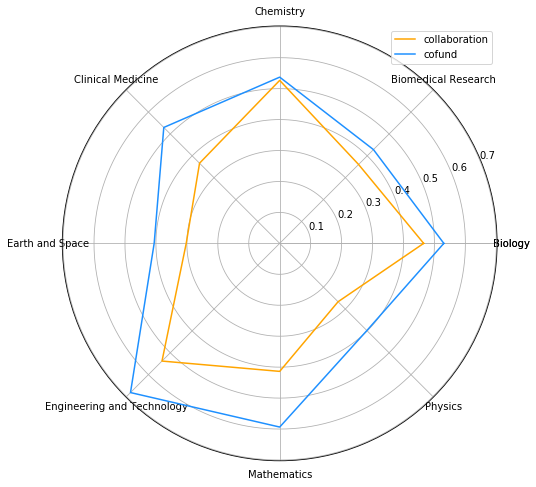

In [97]:
fig=plt.figure(figsize=(8,8))
ax=plt.subplot(polar=True)
fig, ax=plot_ratio("South Africa")
plt.legend()

In [99]:
cntry_info_path='..//..//data//nf_folder//Data//AdditionalData//country_metadata.csv'
cntry_info=pd.read_csv(cntry_info_path)
cntry_info.head(2)

,wos_country,country,continent,subregion,country_iso_alpha,ST,country_iso_2,language,ethnologue_family,glottologue_first_family,glottologue_second_family
0,Afghanistan,Afghanistan,Asia,Southern Asia,AFG,Others,AF,fa,Iranian,Indo-European,Indo-Iranian
1,Albania,Albania,Europe,Southern Europe,ALB,Lagging,AL,el,Hellenic,Indo-European,Graeco-Phrygian


In [103]:
ctnent=cntry_info[['wos_country','continent']]
ctnent.head(2)

,wos_country,continent
0,Afghanistan,Asia
1,Albania,Europe


In [106]:
cntry_meta=cntry_meta.merge(ctnent,left_on='author_distinct',right_on='wos_country')
cntry_meta

,author_distinct,level_2,count,collcount,fundcount,coll_ratio,fund_ratio,wos_country,continent
0,Afghanistan,Biology,53,48.0,27.0,0.094340,0.490566,Afghanistan,Asia
1,Afghanistan,Biomedical Research,37,37.0,22.0,0.000000,0.405405,Afghanistan,Asia
2,Afghanistan,Chemistry,12,12.0,4.0,0.000000,0.666667,Afghanistan,Asia
3,Afghanistan,Clinical Medicine,267,244.0,111.0,0.086142,0.584270,Afghanistan,Asia
4,Afghanistan,Earth and Space,17,17.0,11.0,0.000000,0.352941,Afghanistan,Asia
...,...,...,...,...,...,...,...,...,...
1337,Zimbabwe,Clinical Medicine,1143,1019.0,751.0,0.108486,0.342957,Zimbabwe,Africa
1338,Zimbabwe,Earth and Space,312,216.0,127.0,0.307692,0.592949,Zimbabwe,Africa
1339,Zimbabwe,Engineering and Technology,101,73.0,27.0,0.277228,0.732673,Zimbabwe,Africa
1340,Zimbabwe,Mathematics,69,49.0,28.0,0.289855,0.594203,Zimbabwe,Africa


In [109]:
ctnent_coll = cntry_meta.groupby(['continent','level_2'])['coll_ratio'].mean().reset_index()
ctnent_coll=ctnent_coll.pivot(index='continent',columns='level_2',values='coll_ratio')
ctnent_coll.head()

level_2,Biology,Biomedical Research,Chemistry,Clinical Medicine,Earth and Space,Engineering and Technology,Mathematics,Physics
continent,,,,,,,,
Africa,0.115083,0.088698,0.125451,0.144883,0.109419,0.160186,0.285894,0.138727
Asia,0.274323,0.248518,0.325345,0.330548,0.252961,0.320677,0.388700,0.284287
Europe,0.347515,0.311768,0.427881,0.373832,0.275166,0.420797,0.465224,0.251422
North America,0.166271,0.141232,0.179527,0.201146,0.114104,0.232100,0.200403,0.187006
Oceania,0.103650,0.065315,0.199658,0.088939,0.076056,0.321193,0.319477,0.163197


In [136]:
ctnent_fund = cntry_meta.groupby(['continent','level_2'])['fund_ratio'].mean().reset_index()
ctnent_fund=ctnent_fund.pivot(index='continent',columns='level_2',values='fund_ratio')
ctnent_fund

level_2,Biology,Biomedical Research,Chemistry,Clinical Medicine,Earth and Space,Engineering and Technology,Mathematics,Physics
continent,,,,,,,,
Africa,0.433276,0.327741,0.476075,0.474385,0.444943,0.584995,0.657418,0.471299
Asia,0.543115,0.471878,0.574226,0.647615,0.498874,0.641871,0.688920,0.531607
Europe,0.526365,0.453842,0.508873,0.612439,0.459589,0.614947,0.620026,0.395456
North America,0.432492,0.360726,0.415945,0.571781,0.359897,0.579528,0.524100,0.433659
Oceania,0.338610,0.312855,0.355761,0.365577,0.263790,0.415685,0.773232,0.453221
South America,0.486229,0.431370,0.478427,0.601321,0.400740,0.555571,0.610589,0.371230


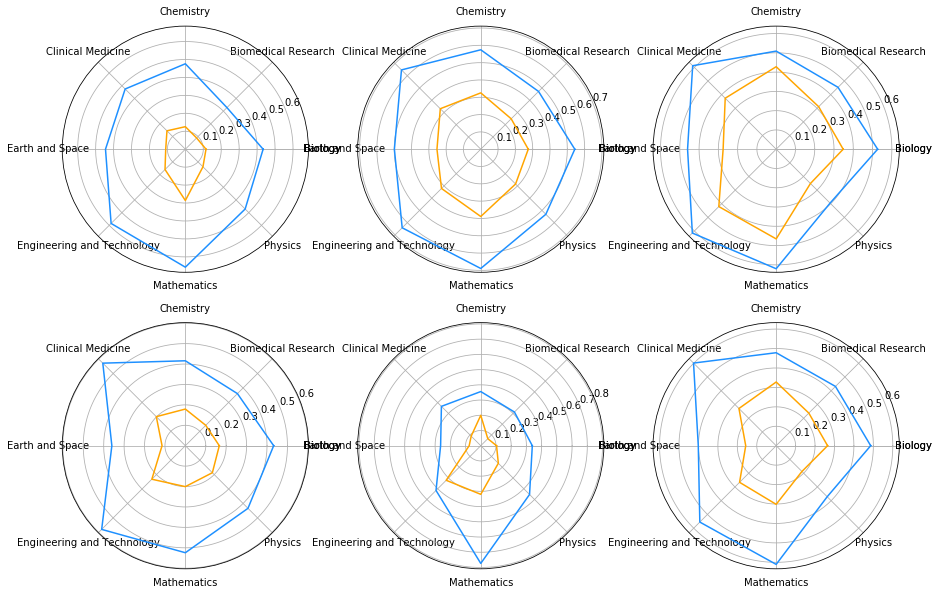

In [134]:
nrows=2
ncols=3
fig=plt.figure(figsize=(15,10))
for ind,c in enumerate(ctnent_fund.index.tolist()):
    ax=plt.subplot(nrows,ncols,ind+1,polar=True)
    plot_ratio(c,ctnent_coll,ctnent_fund,fig,ax)

In [144]:
income_path='..//..//data//nf_folder//Data//AdditionalData//cntry_year_incomegroup.csv'
income_df=pd.read_csv(income_path)
income_df=income_df[income_df.YEAR=='2013-2017']
income_df.head()

,Code,IncomeGroup,YEAR,WoS
5,AFG,L,2013-2017,Afghanistan
11,ALB,UM,2013-2017,Albania
17,DZA,UM,2013-2017,Algeria
23,AND,H,2013-2017,Andorra
29,AGO,UM,2013-2017,Angola


In [146]:
cntry_meta=cntry_meta.merge(income_df,left_on='author_distinct',right_on='WoS')

In [148]:
cntry_meta.head(2)

,author_distinct,level_2,count,collcount,fundcount,coll_ratio,fund_ratio,wos_country,continent,Code,IncomeGroup,YEAR,WoS
0,Afghanistan,Biology,53,48.0,27.0,0.09434,0.490566,Afghanistan,Asia,AFG,L,2013-2017,Afghanistan
1,Afghanistan,Biomedical Research,37,37.0,22.0,0.00000,0.405405,Afghanistan,Asia,AFG,L,2013-2017,Afghanistan


In [149]:
income_coll = cntry_meta.groupby(['IncomeGroup','level_2'])['coll_ratio'].mean().reset_index()
income_coll=income_coll.pivot(index='IncomeGroup',columns='level_2',values='coll_ratio')
income_coll.head()

level_2,Biology,Biomedical Research,Chemistry,Clinical Medicine,Earth and Space,Engineering and Technology,Mathematics,Physics
IncomeGroup,,,,,,,,
H,0.322654,0.275964,0.370830,0.354898,0.236953,0.366918,0.416379,0.260970
L,0.068750,0.040999,0.069969,0.095897,0.051565,0.082324,0.221340,0.077086
LM,0.168780,0.149773,0.225845,0.202486,0.163071,0.220700,0.345202,0.234265
UM,0.233605,0.215491,0.304319,0.255860,0.208805,0.358626,0.340856,0.227395


In [151]:
income_fund = cntry_meta.groupby(['IncomeGroup','level_2'])['fund_ratio'].mean().reset_index()
income_fund=income_fund.pivot(index='IncomeGroup',columns='level_2',values='fund_ratio')
income_fund.head()

level_2,Biology,Biomedical Research,Chemistry,Clinical Medicine,Earth and Space,Engineering and Technology,Mathematics,Physics
IncomeGroup,,,,,,,,
H,0.509653,0.425794,0.488412,0.611836,0.425511,0.596890,0.605758,0.402988
L,0.417035,0.289455,0.446690,0.428666,0.385545,0.503928,0.668640,0.435608
LM,0.460955,0.376643,0.498218,0.517768,0.435903,0.584383,0.648783,0.518158
UM,0.488870,0.455094,0.532378,0.605554,0.469694,0.633219,0.671877,0.511431


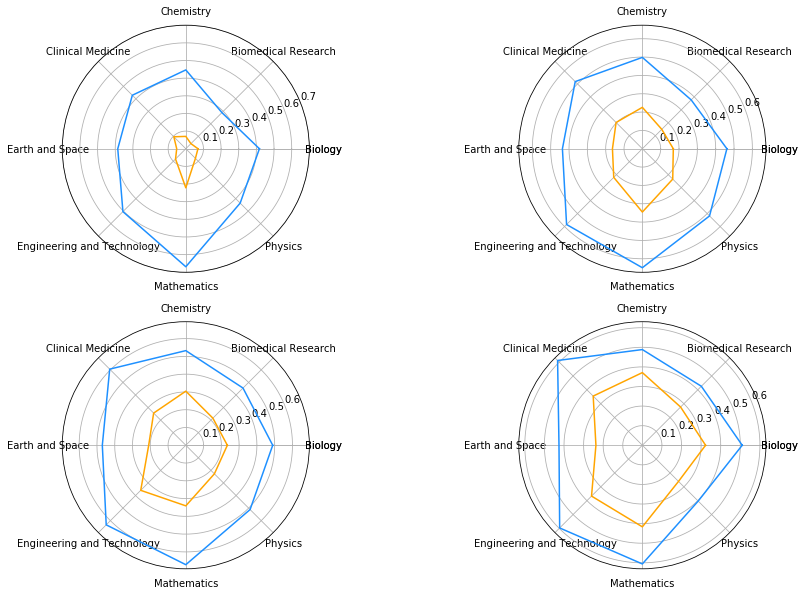

In [165]:
nrows=2
ncols=2
fig=plt.figure(figsize=(15,10))
for ind,c in enumerate(['L','LM','UM','H']):
    ax=plt.subplot(nrows,ncols,ind+1,polar=True)
    plot_ratio(c,income_coll,income_fund,fig,ax)

In [158]:
pubs_author_funder[(pubs_author_funder.fundflow==0)&(pubs_author_funder.coll==1)]

,id,author_country,funder_country,discipline,year,rel_citation,citation,author_distinct,funder_distinct,coll,fundflow
7739782,30258899,"[United States, Vietnam]",Not-Funded,88,2009,4.394,58,"[United States, Vietnam]",Not-Funded,1,0
7739783,30258900,"[France, Vietnam]",Not-Funded,88,2009,0.379,5,"[France, Vietnam]",Not-Funded,1,0
7739784,30258901,"[France, Romania]",Not-Funded,88,2009,0.379,5,"[France, Romania]",Not-Funded,1,0
7739789,30310530,"[France, Chile, Chile]",Not-Funded,88,2009,0.379,5,"[Chile, France]",Not-Funded,1,0
7739792,30310533,"[Chile, United States]",Not-Funded,88,2009,0.758,10,"[United States, Chile]",Not-Funded,1,0
...,...,...,...,...,...,...,...,...,...,...,...
12759088,65300574,"[South Korea, United States]",Not-Funded,37,2018,0.000,0,"[South Korea, United States]",Not-Funded,1,0
12759108,65300622,"[India, Spain, India, India, India, India]",Not-Funded,82,2018,0.000,0,"[India, Spain]",Not-Funded,1,0
12759115,65300866,"[Spain, Spain, Australia]",Not-Funded,49,2017,0.000,0,"[Spain, Australia]",Not-Funded,1,0
12759117,65300906,"[Denmark, Denmark, Australia]",Not-Funded,55,2018,0.000,0,"[Denmark, Australia]",Not-Funded,1,0


0.9801980198019802